In [1]:
import logging
logging.root.setLevel(logging.INFO)


In [2]:
import random

from xcs import XCSAlgorithm
from xcs.scenarios import Scenario

In [3]:
import random

from xcs.scenarios import Scenario
from xcs.bitstrings import BitString

# environment setup
import gym
# noinspection PyUnresolvedReferences
import gym_maze


class MazeScenario(Scenario):
    
    def __init__(self, exploration_cycles, exploitation_cycles, input_size=8):
        self.input_size = input_size
        self.maze = gym.make('Maze5-v0')
        self.possible_actions = (0, 1, 2, 3, 4, 5, 6, 7)
        self.done = False
        self.state = None
        self.reward = 0
        self.state = self.maze.reset()
        self.remaining_cycles = exploration_cycles
        self.exploration_cycles = exploration_cycles
        self.exploitation_cycles = exploitation_cycles
        
        self.steps_array = []
        self.steps = 0

    def reset(self):
        self.done = False
        self.state = self.maze.reset()
        no_reward_state=[]
        for char in self.state:
            if char == '1' or char == '0':
                no_reward_state.append(char)
            else:
                no_reward_state.append('1')
        return no_reward_state
    
    def switch_to_explitation(self):
        self.remaining_cycles = self.exploitation_cycles
        
    # XCS Hosford42 functions
    @property
    def is_dynamic(self):
        return False
        
    def get_possible_actions(self):
        return self.possible_actions
        
    def more(self):
        if self.done:
            self.reset()
            self.remaining_cycles -= 1
            self.steps_array.append(self.steps)
            self.steps = 0
            self.reset()
        return self.remaining_cycles >=0
        
    def sense(self):
        no_reward_state=[]
        for char in self.state:
            if char == '1' or char == '0':
                no_reward_state.append(char)
            else:
                no_reward_state.append('1')
        return BitString(''.join(no_reward_state))
    
    def execute(self, action):
        self.steps += 1
        raw_state, step_reward, done, _ = self.maze.step(action)
        self.state = raw_state
        self.reward = step_reward
        self.done = done
        return self.reward

    # XCS Pyalcs functions
    def step(self, action):
        raw_state, step_reward, done, _ = self.maze.step(action)
        self.state = raw_state
        self.reward = step_reward
        self.done = done
        no_reward_state=[]
        for char in self.state:
            if char == '1' or char == '0':
                no_reward_state.append(char)
            else:
                no_reward_state.append('1')
        return no_reward_state, self.reward, self.done, _

In [4]:
exploration_cycles = 4000
exploitation_cycles = 1000
input_size = 8
logging.root.setLevel(logging.INFO)
scenario = MazeScenario(exploration_cycles, exploitation_cycles, input_size)

In [5]:
import numpy as np
algorithm = XCSAlgorithm()
algorithm.max_population_size = 1600          # N
algorithm.learning_rate = .2                 # beta
algorithm.accuracy_coefficient = .1          # alpha
algorithm.error_threshold = .01              # epsilon_0
algorithm.accuracy_power = 5                 # nu
algorithm.discount_factor = .71              # gamma
algorithm.ga_threshold = 35                  # theta_GA
algorithm.crossover_probability = .8         # chi
algorithm.mutation_probability = .01         # mu
algorithm.deletion_threshold = 20            # theta_del
algorithm.fitness_threshold = .1             # delta
algorithm.subsumption_threshold = 20         # theta_sub
algorithm.wildcard_probability = .3          # P_#
algorithm.initial_prediction = 10        # p_I
algorithm.initial_error = .00001             # epsilon_I
algorithm.initial_fitness = 10           # F_I
algorithm.exploration_probability = .5       # p_exp
algorithm.minimum_actions = 8             # theta_mna
algorithm.do_ga_subsumption = False          # doGASubsumption
algorithm.do_action_set_subsumption = False  # doActionSetSubsumption

In [6]:
model = algorithm.new_model(scenario)
model.run(scenario, learn=True)
scenario.switch_to_explitation()
model.algorithm.exploration_probability = 0
model.run(scenario, learn=True)

In [7]:
print(len(model))

176


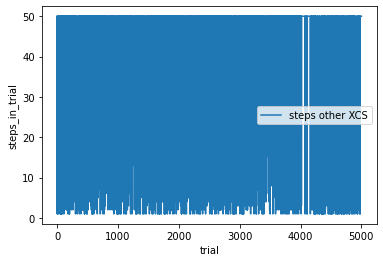

In [8]:
import pandas as pd

df = pd.DataFrame(scenario.steps_array)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("steps_in_trial")
ax.legend(["steps other XCS"])

In [9]:
from lcs.agents.xcs import Configuration

cfg = Configuration(
    number_of_actions=algorithm.minimum_actions,
    covering_wildcard_chance=1-algorithm.wildcard_probability,
    max_population=algorithm.max_population_size,
    learning_rate=algorithm.learning_rate,
    alpha=algorithm.accuracy_coefficient,
    epsilon_0=algorithm.error_threshold,
    v=algorithm.accuracy_power,
    gamma=algorithm.discount_factor,
    ga_threshold=algorithm.ga_threshold,
    chi=algorithm.crossover_probability,
    mutation_chance=algorithm.mutation_probability,
    deletion_threshold=algorithm.deletion_threshold,
    delta=algorithm.fitness_threshold,
    subsumption_threshold=algorithm.subsumption_threshold,
    initial_prediction=algorithm.initial_prediction,
    initial_error=algorithm.initial_error,
    initial_fitness=algorithm.initial_fitness,
    epsilon=algorithm.exploration_probability)



In [10]:
from lcs.agents.xcs import XCS
from utils.xcs_utils import *

agent = XCS(cfg)
my_df = avg_experiment(scenario,
                    cfg,
                    number_of_tests=1,
                    explore_trials=exploration_cycles,
                    exploit_metrics=exploitation_cycles)


INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 50, 'reward': [0, 0, 0, 0, 0, 0, 0, 337.47325870994104], 'perf_time': 0.006538899999952719}


Executing 0 experiment


INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 50, 'reward': [1.0148173383781874e+19, 4.073459928830947e+19, 3.518826850895822e+19, 2.897046519622881e+19, 2.4630615109386056e+20, 2.4114153513675758e+20, 7.833037695324916e+20, 1.7307065797555233e+18], 'perf_time': 0.027840399999945475}
INFO:lcs.agents.Agent:{'trial': 800, 'steps_in_trial': 50, 'reward': [1.573269138376133e+24, 1.3731331491908394e+27, 5.425354965009374e+26, 7.086928620932512e+27, 7.21007351642932e+26, 2.9990373080629794e+26, 1.4251708662289594e+27, 1.4361398509435144e+27], 'perf_time': 0.02816899999999123}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 50, 'reward': [7.310660883119861e+32, 1.1661542271202125e+34, 6.785451784458224e+30, 1.2820989055527648e+32, 4.950309370208078e+32, 7.822677909196943e+32, 2.636174650764915e+34, 7.510091034367179e+32], 'perf_time': 0.03053299999999126}
INFO:lcs.agents.Agent:{'trial': 1600, 'steps_in_trial': 50, 'reward': [1.050769430143061e+39, 9.50693823658764e+37, 9.0104

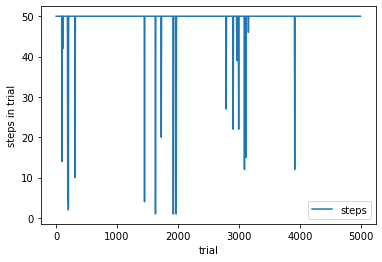

In [11]:
import pandas as pd

ax = my_df['steps_in_trial'].plot()
ax.set_xlabel("trial")
ax.set_ylabel("steps in trial")
ax.legend(["steps"])


#### Conclusions
Conclusion to previous tests: Performing test with default values to my implementation, 4000 explore trials, 1000 exploit trials showed that both algorithms behave similarly. 
<br />
The tests with values mirroring the ones from An Analysis of Generalization in the XCS Classifier System resulted in both XCS performing worse than in original test.